In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Count data

From Wikipedia:

> The Poisson distribution is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time if these events occur with a known constant mean rate and independently of the time since the last event.

#### Rate parameter $\lambda$

Expected number of events in the fixed time interval

#### Probability mass function
$$
x\sim \operatorname{Poisson}(\lambda)\qquad\Longleftrightarrow\qquad \mathbb{P}[x=k] = e^{-\lambda}\frac{\lambda^k}{k!},\quad k=0,1,\ldots
$$

#### Expectation and variance
If $x\sim \operatorname{Poisson}(\lambda)$, then
$$
\mathbb{E}[x] = \lambda\qquad\text{and}\qquad\mathbb{V}[x]=\lambda.
$$

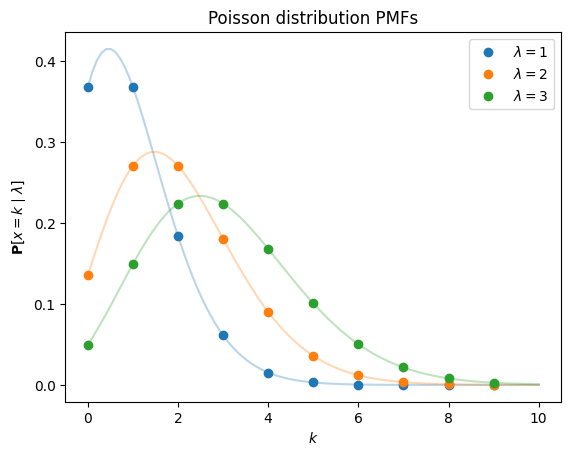

In [2]:
import scipy.stats as stats
import scipy.special as special

ks = np.arange(10)
ts = np.linspace(0, 10, 100)
for i in range(3):
    plt.plot(ks, stats.poisson(i + 1).pmf(ks), "o", label=f"$\\lambda={i + 1}$")
    plt.plot(
        ts, np.exp(-(i + 1)) * (i + 1) ** ts / special.gamma(ts + 1), f"C{i}", alpha=0.3
    )
plt.legend()
plt.title("Poisson distribution PMFs")
plt.xlabel("$k$")
plt.ylabel("$\\mathbf{P}[x=k\\mid\\lambda]$")
plt.show()

### Mule kicks

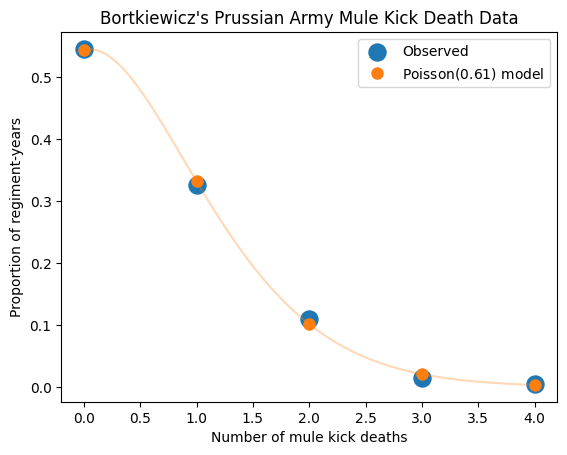

In [3]:
counts = np.arange(5)
count_occurences = np.array([109, 65, 22, 3, 1])
lam = np.sum(count_occurences * counts) / count_occurences.sum()
plt.scatter(counts, count_occurences / count_occurences.sum(), s=150, label="Observed")
plt.plot(
    counts,
    stats.poisson(lam).pmf(counts),
    "oC1",
    ms=8,
    label=f"$\\operatorname{{Poisson}}({lam:.2f})$ model",
)
ts = np.linspace(0, 4, 100)
plt.plot(ts, np.exp(-lam) * lam**ts / special.gamma(ts + 1), "C1", alpha=0.3)
plt.xlabel("Number of mule kick deaths")
plt.ylabel("Proportion of regiment-years")
plt.title("Bortkiewicz's Prussian Army Mule Kick Death Data")
plt.legend()
plt.show()

### Poisson Regression

- Counts $y$ might depend on predictors $x\in\mathbb{R}^p$ through the rate parameter $\lambda$.

- For example: The number of awards a student wins in a year might be associated with their program of study and on a standardized test score.

In [4]:
df = pd.read_csv("https://stats.idre.ucla.edu/stat/data/poisson_sim.csv")
df

,id,num_awards,prog,math
0,45,0,3,41
1,108,0,1,41
2,15,0,3,44
3,67,0,3,42
4,153,0,3,40
...,...,...,...,...
195,100,2,2,71
196,143,2,3,75
197,68,1,2,71
198,57,0,2,72


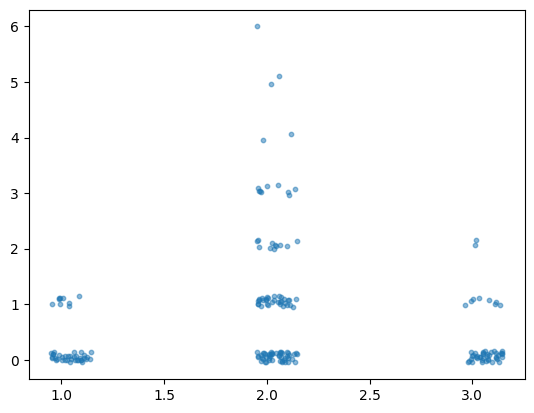

In [ ]:
plt.scatter(
    df["prog"] + np.random.uniform(size=200) * 0.2 - 0.05,
    df["num_awards"] + np.random.uniform(size=200) * 0.2 - 0.05,
    s=10,
    alpha=0.5,
)

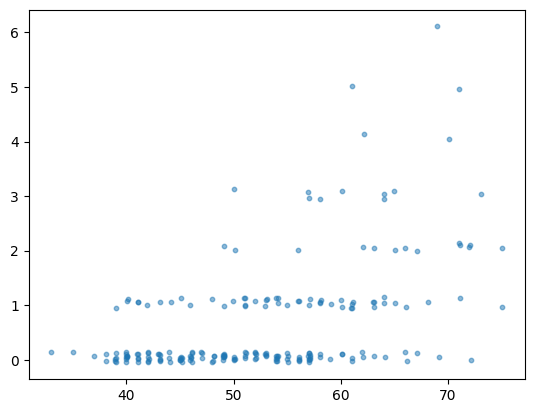

In [ ]:
plt.scatter(
    df["math"] + np.random.uniform(size=200) * 0.2 - 0.05,
    df["num_awards"] + np.random.uniform(size=200) * 0.2 - 0.05,
    s=10,
    alpha=0.5,
)

### Log-linear modeling of count data

- Since $\lambda > 0$, it doesn't make sense to represent lambda as a linear function of predictors. Model $\lambda$ as the exponential of a linear function of the predictors: $\lambda=e^{\beta\cdot x\cdot}$.

- Model counts data by a Poisson distribution whose rate depends on the predictor vector $x$ as above:
  $$
  y\sim\operatorname{Poisson}(e^{\beta\cdot x})
  $$